# Try community detection

In [5]:
# use autoreload
%load_ext autoreload
%autoreload 2

import yaml
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import seaborn as sns
import torch

# import lightning trainer
import lightning as L
from lightning.pytorch.loggers import WandbLogger

# imports
from jepa.modules import TrueContrastiveLearning

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Evaluation embeddings

In [2]:
with open("configs/4c_testing.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/UnsupervisedLearning/JEPA/ToyTrack/2_testing/artifacts/best-92512mhb-val_loss=0.003267-epoch=99.ckpt"

# Use lightning load
model = TrueContrastiveLearning.load_from_checkpoint(checkpoint_path).to("cuda")

# Get dataloader
dataloader = model.train_dataloader()

# Get a batch
batch = next(iter(dataloader))

Max edge index: 19
Distances shape: torch.Size([38000])
Sample distances: tensor([3.1563e-02, 7.1974e+01, 7.1967e+01, 1.5368e+01, 1.5381e+01],
       device='cuda:0')


/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/pytorch/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


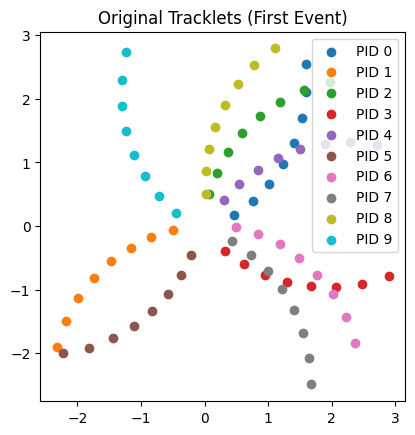

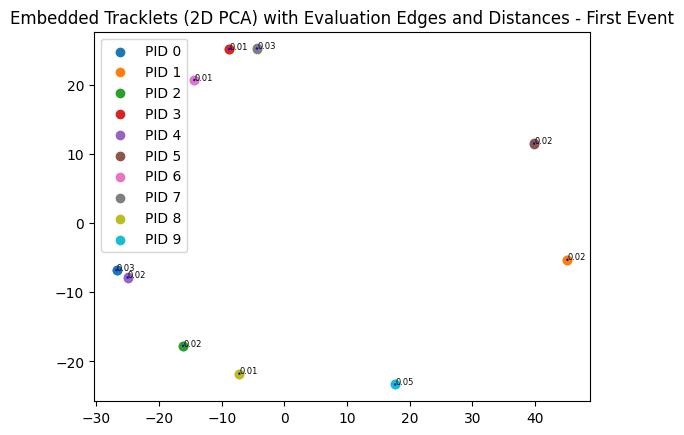

First Batch Metrics:
  Efficiency: 1.0000
  Purity: 0.9333
  Mean True Distance: 0.0216
  Mean Fake Distance: 39.7294


In [6]:
with torch.no_grad():
    batch = {k: v.to("cuda") if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    results = model.shared_evaluation(batch, batch_idx=0)

# Get the embeddings
low_pt_embeddings = results["embeddings"].cpu().numpy()

In [20]:
with torch.no_grad():
    x, mask, pids, edge_index, edge_mask, y = model._extract_batch_data(batch)
    x_flat = model._flatten_tracklets(x)
    embedded_tracklets = model._embed_tracklets(x_flat)
    embeddings_0, embeddings_1 = model._get_edge_embeddings(
        embedded_tracklets, edge_index, edge_mask, x.shape[1]
    )
    distances = model._compute_distances(embeddings_0, embeddings_1)
    loss = model._compute_loss(distances, y, edge_mask)

Max edge index: 19
Distances shape: torch.Size([38000])
Sample distances: tensor([3.1563e-02, 7.1974e+01, 7.1967e+01, 1.5368e+01, 1.5381e+01],
       device='cuda:0')


In [21]:
for radius in np.linspace(0.1, 1.0, 10):
    model.hparams["radius"] = radius
    efficiency, purity = model._calculate_metrics(distances, y, edge_mask)
    print(f"Radius: {radius}, Efficiency: {efficiency}, Purity: {purity}")


Radius: 0.1, Efficiency: 0.9984999895095825, Purity: 0.9910669922828674
Radius: 0.2, Efficiency: 1.0, Purity: 0.9891197085380554
Radius: 0.30000000000000004, Efficiency: 1.0, Purity: 0.9784736037254333
Radius: 0.4, Efficiency: 1.0, Purity: 0.9713453054428101
Radius: 0.5, Efficiency: 1.0, Purity: 0.960614800453186
Radius: 0.6, Efficiency: 1.0, Purity: 0.9541984796524048
Radius: 0.7000000000000001, Efficiency: 1.0, Purity: 0.9501187801361084
Radius: 0.8, Efficiency: 1.0, Purity: 0.9442870616912842
Radius: 0.9, Efficiency: 1.0, Purity: 0.9380863308906555
Radius: 1.0, Efficiency: 1.0, Purity: 0.9332711100578308


In [8]:
distances.shape

torch.Size([38000])

In [9]:
y.shape, y[edge_mask].shape

(torch.Size([200, 190]), torch.Size([38000]))

In [13]:
y.sum()

tensor(2000, device='cuda:0')

In [19]:
(distances < 0.1).sum()

tensor(2015, device='cuda:0')

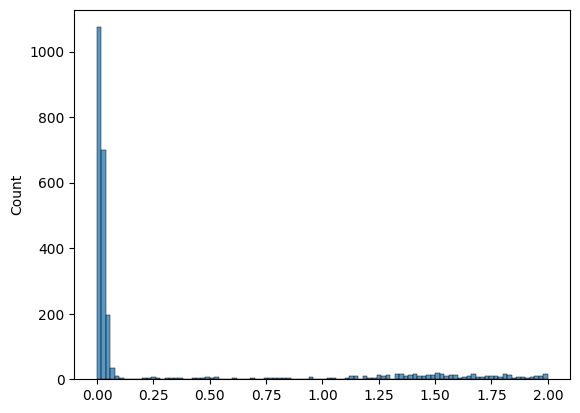

In [17]:
# Hist of distances from 0 to 2
sns.histplot(distances.cpu(), bins=100, binrange=(0, 2))
plt.show()

In [12]:
(
    (distances < 1) & (y[edge_mask].bool())
).sum()

tensor(2000, device='cuda:0')

In [18]:
(
    (distances < 0.1) & (y[edge_mask].bool())
).sum()

tensor(1997, device='cuda:0')